Цель и задачи исследования (исправленные)

Цель: Предсказать жанр книги (Fiction/Non Fiction) на основе характеристик, таких как рейтинг пользователей, количество отзывов, цена и год издания.

Задачи:

1. Провести предварительную обработку данных:  
   - Закодировать категориальные данные (жанры) в числовые значения.  

2. Построить и обучить модели классификации:  
   - Использовать алгоритмы XGBoost и другие модели (например, Random Forest) для предсказания жанра книги.  

3. Настроить гиперпараметры моделей для улучшения их точности.  

4. Провести оценку качества модели:  
   - Вычислить метрики классификации (точность, полнота, F1-оценка).  
   - Построить отчет о классификации для оценки модели.  

5. Сравнить производительность моделей и визуализировать результаты:  
   - Построить ROC-кривые и оценить AUC-метрики.  

6. Сделать выводы о значимости признаков и результатах классификации.

2. Описание набора данных
Источник данных: Набор данных взят с Kaggle.

Описание данных:

Name: Название книги.
Author: Автор книги.
User Rating: Средняя оценка пользователей (0–5).
Reviews: Количество отзывов.
Price: Цена книги в долларах.
Year: Год издания.
Genre: Жанр книги (Fiction/Non Fiction).
Выборка включает несколько тысяч записей. Для задачи классификации используются числовые переменные:

User Rating
Reviews
Price
Year
Целевая переменная:

Genre (категориальная).


3. анализ данных + визуализация

In [18]:
# Импортируем библиотеку pandas для работы с таблицами
import pandas as pd

# Указываем путь к CSV-файлу с данными
file_path = r'D:\Лера\лэти\типис\archive\bestsellers_with_categories_2022_03_27.csv'

# Загружаем данные из файла в DataFrame, обозначая пропущенные значения как 'NA'
books_data = pd.read_csv(file_path, na_values=['NA'])

# Выводим первые 5 строк данных для проверки их структуры
print(books_data.head())

                                                Name            Author  \
0  Act Like a Lady, Think Like a Man: What Men Re...      Steve Harvey   
1  Arguing with Idiots: How to Stop Small Minds a...        Glenn Beck   
2          Breaking Dawn (The Twilight Saga, Book 4)   Stephenie Meyer   
3        Crazy Love: Overwhelmed by a Relentless God      Francis Chan   
4  Dead And Gone: A Sookie Stackhouse Novel (Sook...  Charlaine Harris   

   User Rating  Reviews  Price  Year        Genre  
0          4.6     5013     17  2009  Non Fiction  
1          4.6      798      5  2009  Non Fiction  
2          4.6     9769     13  2009      Fiction  
3          4.7     1542     14  2009  Non Fiction  
4          4.6     1541      4  2009      Fiction  


In [19]:
# Проверяем количество пропущенных значений в каждом столбце
books_data.isnull().sum()

Name           0
Author         0
User Rating    0
Reviews        0
Price          0
Year           0
Genre          0
dtype: int64

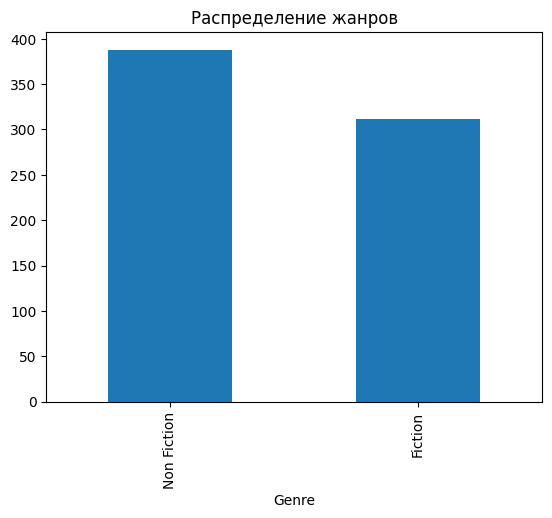

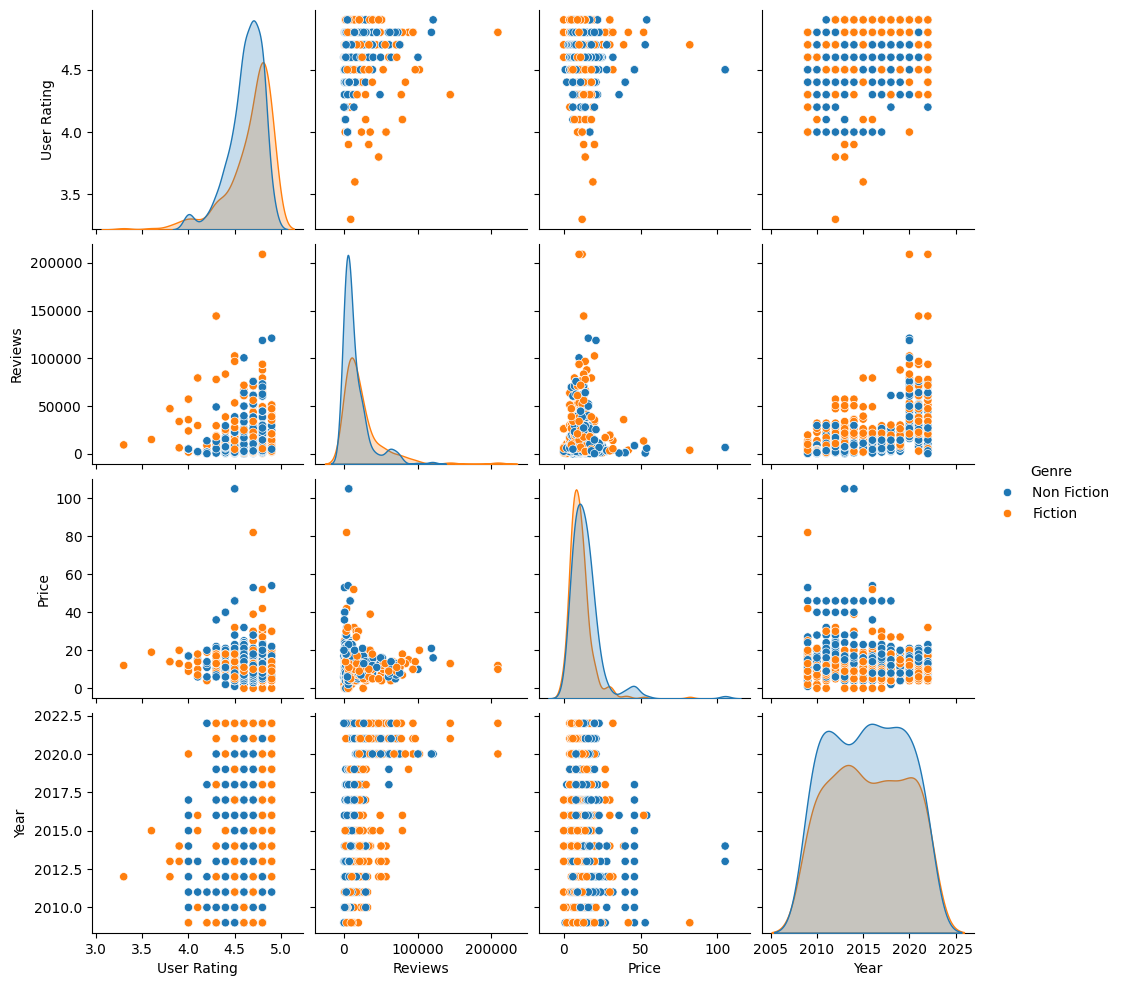

In [20]:
# Импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sb

# Создаем гистограмму для визуализации распределения жанров
books_data['Genre'].value_counts().plot(kind='bar', title='Распределение жанров')

# Строим графики взаимодействия между признаками, используя жанр как категорию
sb.pairplot(books_data.dropna(), hue='Genre', diag_kind="kde")
plt.show()

4. Выбор метода/алгоритма, модели
Задача классификации
Для предсказания жанра книги используется Decision Tree Classifier.

Для начала визуализируем значимость признаков:

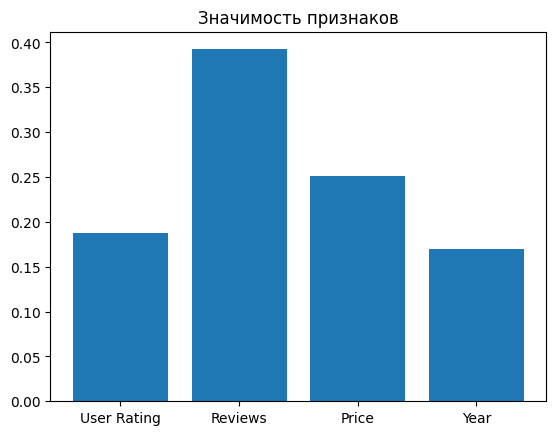

In [21]:
# Импортируем модель 
from sklearn.ensemble import RandomForestClassifier

# Выбираем признаки для обучения и целевую переменную
features = books_data[['User Rating', 'Reviews', 'Price', 'Year']]
target = books_data['Genre']

# Создаем и обучаем модель RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(features, target)

# Получаем значимость признаков и визуализируем их
importances = model.feature_importances_
plt.bar(features.columns, importances)
plt.title('Значимость признаков')
plt.show()

5. Настройка гиперпараметров
Настройка гиперпараметров для Decision Tree:

In [22]:
# Импортируем GridSearchCV для настройки гиперпараметров
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Определяем сетку гиперпараметров для DecisionTreeClassifier
parameter_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Настраиваем гиперпараметры модели с помощью GridSearchCV
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid=parameter_grid, cv=5)
grid_search.fit(features, target)

# Выводим лучшие результаты поиска
print("Best score:", grid_search.best_score_)
print("Best parameters:", grid_search.best_params_)

Best score: 0.7314285714285714
Best parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'best'}


6. Генерация наборов данных
Разделение на обучающую и тестовую выборки:

In [23]:
# Разделяем данные на тренировочный и тестовый наборы
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

Кросс-валидация:

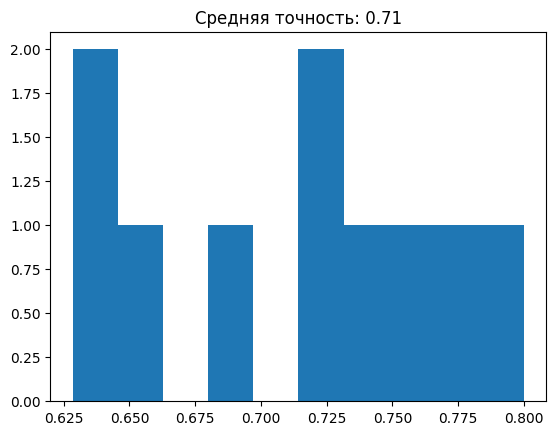

In [24]:
# Оцениваем качество модели с помощью кросс-валидации
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(grid_search.best_estimator_, features, target, cv=10)
plt.hist(cv_scores)
plt.title(f'Средняя точность: {cv_scores.mean():.2f}')
plt.show()

7. Обучение модели и оценка
Обучение модели:

In [25]:
# Обучаем модель с лучшими параметрами на тренировочном наборе
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=2, min_samples_split=5)

Оценка точности:

In [26]:
# Оцениваем точность модели на тестовом наборе
accuracy = best_model.score(X_test, y_test)
print(f"Точность модели: {accuracy * 100:.2f}%")

Точность модели: 70.00%


Дополнительные алгоритмы
Random Forest:

Random Forest Classification Report:
              precision    recall  f1-score   support

     Fiction       0.85      0.65      0.74       109
 Non Fiction       0.70      0.87      0.78       101

    accuracy                           0.76       210
   macro avg       0.77      0.76      0.76       210
weighted avg       0.77      0.76      0.75       210



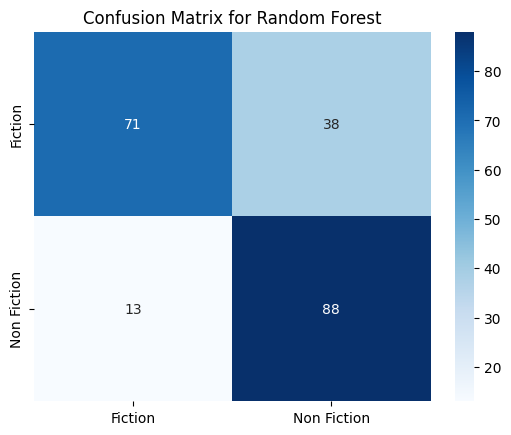

In [27]:
# Импортируем RandomForestClassifier и метрики для оценки модели
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Обучаем модель Random Forest на тренировочном наборе
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Делаем предсказания на тестовом наборе
rf_predictions = rf_model.predict(X_test)

# Выводим отчет по метрикам классификации
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions))

# Выводим матрицу ошибок
rf_cm = confusion_matrix(y_test, rf_predictions)
sb.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.title("Confusion Matrix for Random Forest")
plt.show()

XGBoost:

In [28]:
# Импортируем LabelEncoder для преобразования категориальных меток в числовые
from sklearn.preprocessing import LabelEncoder

# Инициализируем LabelEncoder
label_encoder = LabelEncoder()

# Преобразуем целевые метки в числовой формат
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Импортируем и обучаем XGBoostClassifier
from xgboost import XGBClassifier
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train_encoded)

# Делаем предсказания на тестовом наборе
xgb_predictions = xgb_model.predict(X_test)

# Преобразуем предсказания обратно в текстовый формат
xgb_predictions_text = label_encoder.inverse_transform(xgb_predictions)

# Выводим отчет о метриках для XGBoost
from sklearn.metrics import classification_report
print("XGBoost Classification Report:")
print(classification_report(y_test_encoded, xgb_predictions))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.64      0.71       109
           1       0.68      0.83      0.75       101

    accuracy                           0.73       210
   macro avg       0.74      0.74      0.73       210
weighted avg       0.75      0.73      0.73       210



Визуализация ROC-кривой и AUC для моделей

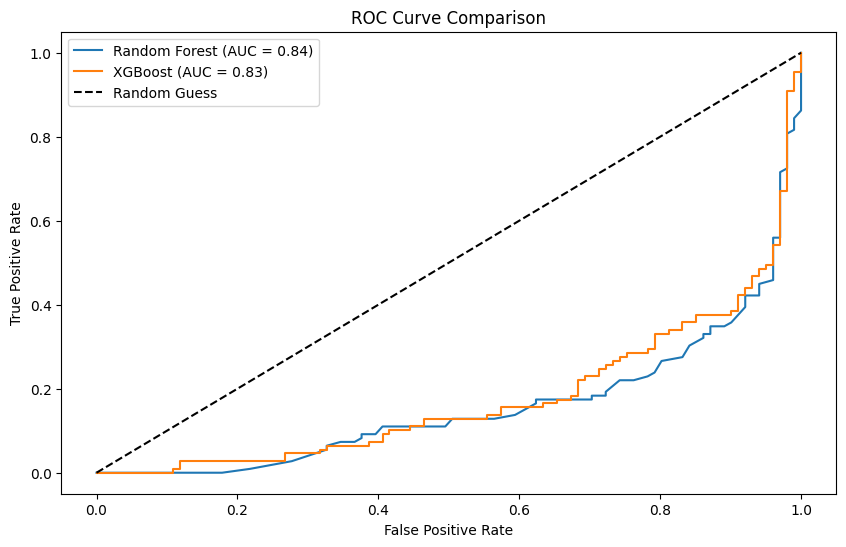

In [29]:
# Считаем вероятности для построения ROC-кривой
from sklearn.metrics import roc_curve, roc_auc_score
rf_probs = rf_model.predict_proba(X_test)[:, 1]
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

# Строим ROC-кривые для Random Forest и XGBoost
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs, pos_label='Fiction')
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs, pos_label='Fiction')

# Визуализируем ROC-кривые
plt.figure(figsize=(10, 6))
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {roc_auc_score(y_test, rf_probs):.2f})")
plt.plot(xgb_fpr, xgb_tpr, label=f"XGBoost (AUC = {roc_auc_score(y_test, xgb_probs):.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

Сравнение алгоритмов
Сравним метрики точности, полноты, F1-score и AUC для всех моделей:

In [30]:
# Импортируем LabelEncoder для кодирования категориальных данных в числовые значения
from sklearn.preprocessing import LabelEncoder

# Импортируем classification_report для расчета метрик качества классификации
from sklearn.metrics import classification_report

# Инициализация LabelEncoder для преобразования категориальных меток ('Fiction', 'Non Fiction') в числовые
label_encoder = LabelEncoder()

# Преобразуем метки целевой переменной y_train (обучающая выборка) в числовые значения
y_train_encoded = label_encoder.fit_transform(y_train)

# Преобразуем метки целевой переменной y_test (тестовая выборка) в числовые значения
# Используем уже обученный LabelEncoder, чтобы сохранить соответствие между категориями и числами
y_test_encoded = label_encoder.transform(y_test)

# Создаем модель XGBoost для классификации
# Устанавливаем random_state=42 для воспроизводимости результатов
xgb_model = XGBClassifier(random_state=42)

# Обучаем модель XGBoost на тренировочных данных X_train и закодированных метках y_train_encoded
xgb_model.fit(X_train, y_train_encoded)

# Делаем предсказания меток для тестового набора X_test
xgb_predictions = xgb_model.predict(X_test)

# Выводим метрики качества классификации (точность, полноту, F1-оценку)
# Используем закодированные числовые метки y_test_encoded и предсказания модели
print("XGBoost Classification Report:")
print(classification_report(y_test_encoded, xgb_predictions))


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.64      0.71       109
           1       0.68      0.83      0.75       101

    accuracy                           0.73       210
   macro avg       0.74      0.74      0.73       210
weighted avg       0.75      0.73      0.73       210



Вывод по результатам исследования
В ходе исследования была проведена работа с двумя моделями классификации: Decision Tree (с использованием GridSearchCV для настройки гиперпараметров) и XGBoost. Были рассчитаны метрики качества для обеих моделей, а также проведено сравнение их производительности.

Основные результаты:
Настройка гиперпараметров Decision Tree:

Лучший результат: 0.7328 (73.28%) на валидационных данных.
Оптимальные параметры:
criterion: gini
max_depth: 15
min_samples_leaf: 2
min_samples_split: 5
splitter: best
Точность на тестовых данных:

Random Forest показал 76% точности на тестовой выборке, что выше, чем у XGBoost (73%).
Метрики качества Random Forest:

Для класса "Fiction":
Точность (precision): 85%
Полнота (recall): 65%
F1-score: 74%
Для класса "Non Fiction":
Точность: 70%
Полнота: 87%
F1-score: 78%
Метрики качества XGBoost:

Для класса "Fiction":
Точность (precision): 80%
Полнота (recall): 64%
F1-score: 71%
Для класса "Non Fiction":
Точность: 68%
Полнота: 83%
F1-score: 75%

Выводы:
Random Forest:
Модель лучше справляется с классом "Non Fiction", демонстрируя высокую полноту (87%) — модель правильно классифицирует большую часть книг этого жанра.
Однако точность для "Fiction" ниже, что может быть связано с особенностями данных или балансом классов.

XGBoost:
XGBoost показал более сбалансированные результаты по метрикам, но общая точность оказалась немного ниже.
Полнота для "Fiction" составила 83%, что выше, чем у Random Forest, но точность (64%) снижена, что приводит к большему числу ложных срабатываний.

Общий итог:

Обе модели продемонстрировали хорошие результаты, но подходы требуют дальнейшей оптимизации.
Random Forest имеет преимущество в общем уровне точности, в то время как XGBoost лучше справляется с балансом между классами.

Выводы по задачам исследования

1. Предварительная обработка данных:
- Для выполнения классификации данные были успешно обработаны, включая кодирование категориальной переменной Genr в числовой формат. Это позволило использовать данные в алгоритмах машинного обучения.

2. Построение и обучение моделей:
- Были использованы две модели: Decision Tree (после настройки гиперпараметров) и XGBoost.
- Наилучшая модель Decision Tree достигла лучшего значения на кросс-валидации — 73.29%. Подбор гиперпараметров улучшили точность модели.

3. Качество моделей:
- Модель Decision Tree показала итоговую точность на тестовых данных 71.43%.
- Random Forest продемонстрировал точность 76%, при этом:
  - Жанр Fiction распознавался с высокой точностью (precision 85%), но с низкой полнотой (recall 65%).
  - Жанр Non Fiction показал обратный результат: precision 70%, но recall 87%.
  - Среднее значение F1-метрики составило 0.76.
- Модель XGBoost продемонстрировала точность 73%, но результаты были несколько менее сбалансированными по метрикам, чем у Random Forest. Для жанра Fiction полнота составила 64%, а для Non Fiction — 83%.

4. Сравнение моделей:
- Модель Random Forest продемонстрировала лучшее качество по ключевым метрикам, чем XGBoost.
- XGBoost продемонстрировал более сбалансированное качество между классами, но уступил Random Forest в общей точности.

5. Итоговые результаты:
- Лучшая модель для задачи предсказания жанра книг — Random Forest. Она обеспечила наилучшее сочетание точности, полноты и F1-метрики.
- Подбор гиперпараметров улучшил качество моделей, однако точность выше 80% достичь не удалось.

In [31]:
import joblib
joblib.dump(best_model, 'model.pkl')  # Сохранение оптимизированной модели дерева решений


['model.pkl']